# 대구 교통사고 수치 예측 과정

## 1. data setting & profiling

In [ ]:
# load modules
import numpy as np
import pandas as pd
import geopandas as gpd
import re

## graph
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager as fm
import matplotlib as mpl

# maps
import folium
from shapely.geometry import MultiPolygon
from pyproj import Proj, transform

%matplotlib inline

: 

In [3]:
plt.rcParams['font.family'] = 'NanumSquare'
plt.rcParams['font.size'] = 10

In [4]:
# load data
fpath = '../Data/external_open/'
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')
acc = pd.read_csv(fpath + "/countrywide_accident.csv")
CCTV = pd.read_csv(fpath + "/대구 CCTV 정보.csv", encoding = 'cp949')
light = pd.read_csv(fpath + "/대구 보안등 정보.csv", encoding = 'cp949', low_memory=False)
child_protect = pd.read_csv(fpath + "/대구 어린이 보호 구역 정보.csv", encoding = 'cp949')
parking = pd.read_csv(fpath + "/대구 주차장 정보.csv", encoding = 'cp949')

In [3]:
# head
train.head(5)

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,...,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,...,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,...,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,36세,중상,0,1,0,0,5
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,52세,경상,0,0,1,0,3


In [4]:
# columns
train.columns

Index(['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형',
       '사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도',
       '피해운전자 차종', '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수',
       '경상자수', '부상자수', 'ECLO'],
      dtype='object')

In [5]:
# dtypes
train.dtypes

ID             object
사고일시           object
요일             object
기상상태           object
시군구            object
도로형태           object
노면상태           object
사고유형           object
사고유형 - 세부분류    object
법규위반           object
가해운전자 차종       object
가해운전자 성별       object
가해운전자 연령       object
가해운전자 상해정도     object
피해운전자 차종       object
피해운전자 성별       object
피해운전자 연령       object
피해운전자 상해정도     object
사망자수            int64
중상자수            int64
경상자수            int64
부상자수            int64
ECLO            int64
dtype: object

In [6]:
# shape
train.shape

(39609, 23)

In [7]:
# describe
train.describe()

,사망자수,중상자수,경상자수,부상자수,ECLO
count,39609.000000,39609.000000,39609.000000,39609.000000,39609.000000
mean,0.007776,0.262365,1.070085,0.126865,4.726704
std,0.090109,0.500845,0.992034,0.394670,3.207206
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,3.000000
50%,0.000000,0.000000,1.000000,0.000000,3.000000
75%,0.000000,0.000000,1.000000,0.000000,6.000000
max,2.000000,6.000000,22.000000,10.000000,74.000000


## 2. 새로운 관계를 알아보기 위한 Data EDA

In [5]:
# date type data
train['사고일시'] = pd.to_datetime(train['사고일시'])

In [6]:
# split year, month, day, hour
train['year'] = train['사고일시'].dt.year
train['month'] = train['사고일시'].dt.month
train['day'] = train['사고일시'].dt.day
train['hour'] = train['사고일시'].dt.hour

In [10]:
# 10이상 이하를 기준으로 고집단 저집단으로 나눔
train['ECLO_group'] = np.where(train['ECLO'] >= 10, "Hard", "Soft")

In [7]:
# 시군구 분리
train['시군구'].unique()
train[['시', '구', '동가']] = train['시군구'].str.split(' ', expand=True)

In [12]:
train.columns

Index(['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형',
       '사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도',
       '피해운전자 차종', '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수',
       '경상자수', '부상자수', 'ECLO', 'year', 'month', 'day', 'hour', 'ECLO_group',
       '시', '구', '동가'],
      dtype='object')

In [13]:
# 선택 데이터
eda = train[['year', 'month', 'day', 'hour', '요일',
             '구', '동가', '기상상태', '노면상태', '도로형태', '사고유형',
             'ECLO', 'ECLO_group']]

In [14]:
# 구 단위
print(eda['구'].unique())

['중구' '달서구' '수성구' '북구' '동구' '서구' '달성군' '남구']


In [15]:
# 동, 가 단위 사건사고 count
eda['동가'].value_counts().sort_values().head(10)

동가
평광동      1
장관동      2
완전동      2
도남동      2
동성로1가    2
신용동      2
동일동      3
화전동      3
계산동1가    3
서야동      3
Name: count, dtype: int64

In [16]:
# 역방향 count
eda['동가'].value_counts().sort_values(ascending=False).head(10)

동가
대명동    1749
범어동    1173
상인동    1143
비산동     968
내당동     938
만촌동     908
평리동     885
산격동     879
신암동     825
송현동     811
Name: count, dtype: int64

In [17]:
# 동가 단위 ELOC
eda.groupby(['동가'])['ECLO'].mean().sort_values(ascending=False)

동가
노곡동      10.333333
덕곡동       9.875000
대안동       9.333333
내동        8.400000
하서동       8.000000
           ...    
서성로2가     3.333333
북성로1가     3.333333
미대동       3.300000
종로2가      2.500000
동일동       2.333333
Name: ECLO, Length: 196, dtype: float64

In [18]:
# location extraction
def process_location_data(df, address_column, drop_columns):
    location_pattern = r'(\S+) (\S+) (\S+)'
    df[['시', '구', '동가']] = df[address_column].str.extract(location_pattern)
    df['동가'] = df['동가'].str.replace('-', '').str.replace(r'\d+$', '', regex=True)
    df = df.drop(drop_columns, axis=1)
    return df

In [19]:
# select data
CCTV2 = process_location_data(CCTV, '소재지지번주소', ['소재지지번주소'])
light2 = process_location_data(light, '소재지지번주소', ['소재지지번주소'])
parking2 = process_location_data(parking, '소재지지번주소', ['소재지지번주소'])
child_protect2 = process_location_data(child_protect, '소재지지번주소', ['소재지지번주소'])

In [20]:
## 도로명주소를 활용하여 동가 손수 찾아내기
# CCTV2[CCTV2['동가'].isna()][['소재지도로명주소', '동가']].to_csv('../Data/cctv_null.csv' ,encoding='cp949' , index=False)
# light2[light2['동가'].isna()][['소재지도로명주소', '동가', '위도', '경도']].to_csv('../Data/light_null.csv', encoding='cp949', index=False)
# parking2[parking2['동가'].isna()][['소재지도로명주소', '동가', '위도', '경도']].to_csv('../Data/parking_null.csv', encoding='cp949', index=False)
# child_protect2[child_protect2['동가'].isna()][['소재지도로명주소', '동가', '위도', '경도']].to_csv('../Data/child_protect_null.csv', encoding='cp949', index=False)

- 주소를 알아내기 위해 https://www.juso.go.kr/openIndexPage.do 를 참조하였습니다.

In [21]:
# 손수 complete
cctv_complete = pd.read_csv('../Data/cctv_null_complete.csv', encoding='cp949')
light_complete = pd.read_csv('../Data/light_null_complete.csv', encoding='cp949')
parking_complete = pd.read_csv('../Data/parking_null_complete.csv', encoding='cp949')
child_protect_complete = pd.read_csv('../Data/child_protect_null.csv', encoding='cp949')

In [39]:
pd.crosstab(CCTV['단속구분'], CCTV['제한속도'])

제한속도,0,30,40,50,60,70,80,100,110
단속구분,,,,,,,,,
1,0,68,11,52,59,9,4,3,1
2,0,148,67,218,126,13,3,0,0
4,232,0,0,0,0,0,0,0,0
99,0,2,2,4,2,0,25,16,0


In [40]:
light2

,보안등위치명,설치개수,소재지도로명주소,위도,경도,설치연도,설치형태,시,구,동가
0,대명1동1,1,대구광역시 남구 현충로 155,35.846703,128.579803,2016.0,한전주,대구광역시,남구,대명동
1,대명1동2,1,대구광역시 남구 현충로31길 10-1,35.846863,128.579406,2016.0,한전주,대구광역시,남구,대명동
2,대명1동3,1,대구광역시 남구 현충로31길 9-8,35.846341,128.579342,2017.0,건축물,대구광역시,남구,대명동
3,대명1동4,2,대구광역시 남구 현충로31길 19-11,35.846368,128.578922,2016.0,한전주,대구광역시,남구,대명동
4,대명1동5,1,대구광역시 남구 현충로29길 22-2,35.845995,128.578858,2016.0,한전주,대구광역시,남구,대명동
...,...,...,...,...,...,...,...,...,...,...
71908,대봉2동 165-9,1,NaN,35.857556,128.600023,NaN,한전주,대구광역시,중구,대봉동
71909,대봉2동 88-85,1,NaN,35.859205,128.600046,NaN,한전주,대구광역시,중구,대봉동
71910,대봉2동 719-20,1,NaN,35.859442,128.599627,NaN,한전주,대구광역시,중구,대봉동
71911,대봉2동 738-13,1,NaN,35.858244,128.597614,2010.0,건축물,대구광역시,중구,대봉동


In [32]:
# 동가 채우기
CCTV2[(CCTV2['동가'].isna()) & (CCTV2['소재지도로명주소'].notnull())]['동가'] = cctv_complete['동가']
light2[(light2['동가'].isna()) & (light2['소재지도로명주소'].notnull())]['동가'] = light_complete['동가']
parking2[(parking2['동가'].isna()) & (parking2['소재지도로명주소'].notnull())]['동가'] = parking_complete['동가']
child_protect2[(child_protect2['동가'].isna()) & (child_protect2['소재지도로명주소'].notnull())]['동가'] = child_protect_complete['동가']

C:\Users\abc\AppData\Local\Temp\ipykernel_18660\683033476.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  light2[(light2['동가'].isna()) & (light2['소재지도로명주소'].notnull())]['동가'] = light_complete['동가']


In [23]:
# not NA
cctv_not_null = CCTV2[CCTV2['동가'].notnull()]
light_not_null = light2[light2['동가'].notnull()]
parking_not_null = parking2[parking2['동가'].notnull()]
child_protect_not_null = child_protect2[child_protect2['동가'].notnull()]

In [60]:
# CCTV 제한속도별 도로 유형
criteria = [(cctv_not_null['단속구분'] == 4),
            (cctv_not_null['제한속도'] <= 40),
            (cctv_not_null['제한속도'] > 40) & (cctv_not_null['제한속도'] <= 70),
            ]
construct = ['cctv_불법주정차_count', 'cctv_보호구역_count', 'cctv_평지도로_count']
cctv_not_null['차도유형'] = np.select(criteria, construct, default='cctv_차량전용_count')

C:\Users\abc\AppData\Local\Temp\ipykernel_18660\1896048862.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cctv_not_null['차도유형'] = np.select(criteria, construct, default='차량전용')


,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,위도,경도,...,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도,시,구,동가,차도유형
0,주차12,대구광역시,남구,시도,NaN,대명로,3,대구광역시 남구 대명로 162,35.838857,128.575418,...,4,0,NaN,NaN,99.0,2010.0,대구광역시,남구,대명동,불법주정차
1,주차13,대구광역시,남구,시도,NaN,봉덕로,3,대구광역시 남구 봉덕로 135,35.844653,128.604619,...,4,0,NaN,NaN,99.0,2013.0,대구광역시,남구,봉덕동,불법주정차
2,주차14,대구광역시,남구,시도,NaN,대봉로,3,대구광역시 남구 봉덕로 134,35.844183,128.604815,...,4,0,NaN,NaN,99.0,2013.0,대구광역시,남구,봉덕동,불법주정차
3,주차15,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 200,35.834798,128.585284,...,4,0,NaN,NaN,99.0,2014.0,대구광역시,남구,대명동,불법주정차
4,주차16,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 243,35.832728,128.588324,...,4,0,NaN,NaN,99.0,2014.0,대구광역시,남구,봉덕동,불법주정차
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,H2418,대구광역시,북구,특별시도,NaN,태암남로,1,대구광역시 북구 태암남로 41,35.925294,128.552023,...,2,40,NaN,NaN,99.0,2021.0,대구광역시,북구,구암동,보호구역
1061,H2419,대구광역시,북구,특별시도,NaN,내곡로,1,대구광역시 북구 내곡로 90,35.900977,128.513825,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,사수동,보호구역
1062,H4145,대구광역시,북구,특별시도,NaN,대현로,2,대구광역시 북구 대현로 100,35.882191,128.609791,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,대현동,보호구역
1063,H4146,대구광역시,북구,특별시도,NaN,대현로,1,대구광역시 북구 대현로 118,35.881737,128.611651,...,2,30,NaN,NaN,2.0,2021.0,대구광역시,북구,대현동,보호구역


In [95]:
# 각 데이터별로 필요하다 생각되는 데이터 별로 생성
cctv_type = pd.crosstab(cctv_not_null['동가'], cctv_not_null['차도유형']).reset_index()
light_type = light_not_null.groupby(['동가'])['설치개수'].sum().reset_index()
parking_type = parking_not_null['동가'].value_counts().reset_index()
child_protect_type = child_protect_not_null['동가'].value_counts().reset_index()

In [96]:
# columns name
parking_type.columns = ['동가', '주차장개수']
child_protect_type.columns = ['동가', '어린이보호구역개수']

In [101]:
# merge
tmp = pd.merge(cctv_type, light_type, how = 'outer', on = '동가')
tmp2 = pd.merge(tmp, parking_type, how = 'outer', on = '동가')
by_dong_factor = pd.merge(tmp2, child_protect_type, how = 'outer', on = '동가')

In [106]:
# change dtypes & imputations
by_dong_factor = by_dong_factor.fillna(0)
by_dong_factor[by_dong_factor.columns.difference(['동가'])] = by_dong_factor[by_dong_factor.columns.difference(['동가'])].astype('int64')

In [108]:
# write csv
by_dong_factor.to_csv('../Data/another_factor.csv', index = False, encoding = 'cp949')

## graph

In [5]:
train.columns

Index(['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형',
       '사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도',
       '피해운전자 차종', '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수',
       '경상자수', '부상자수', 'ECLO'],
      dtype='object')

In [7]:
train.dtypes

ID             object
사고일시           object
요일             object
기상상태           object
시군구            object
도로형태           object
노면상태           object
사고유형           object
사고유형 - 세부분류    object
법규위반           object
가해운전자 차종       object
가해운전자 성별       object
가해운전자 연령       object
가해운전자 상해정도     object
피해운전자 차종       object
피해운전자 성별       object
피해운전자 연령       object
피해운전자 상해정도     object
사망자수            int64
중상자수            int64
경상자수            int64
부상자수            int64
ECLO            int64
dtype: object

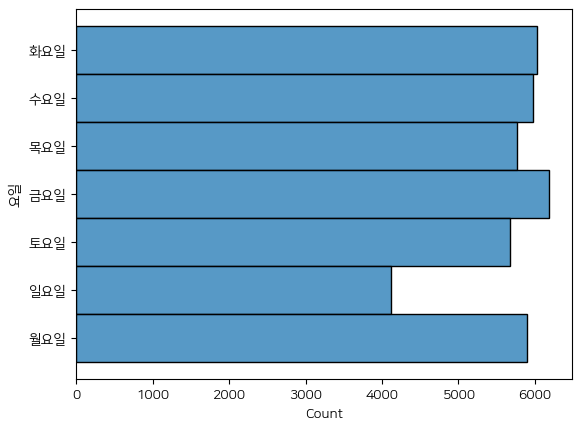

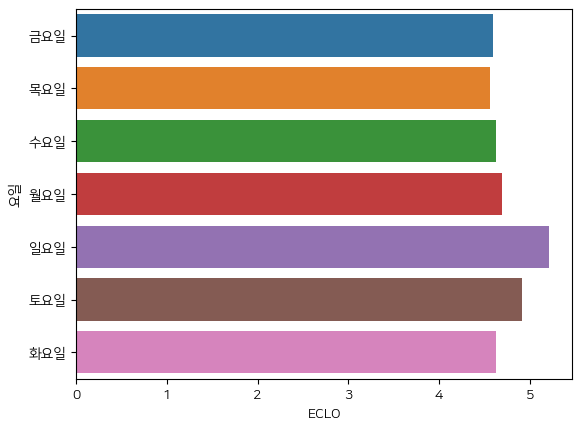

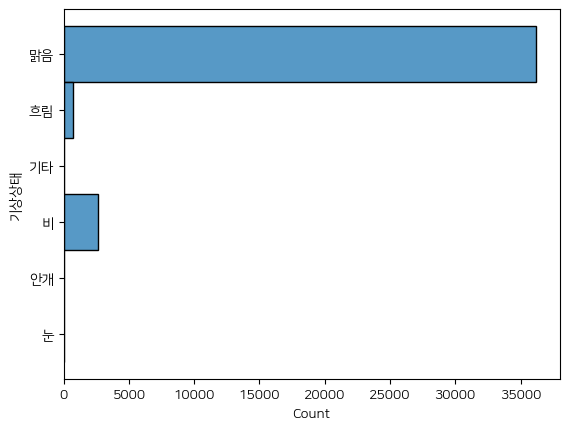

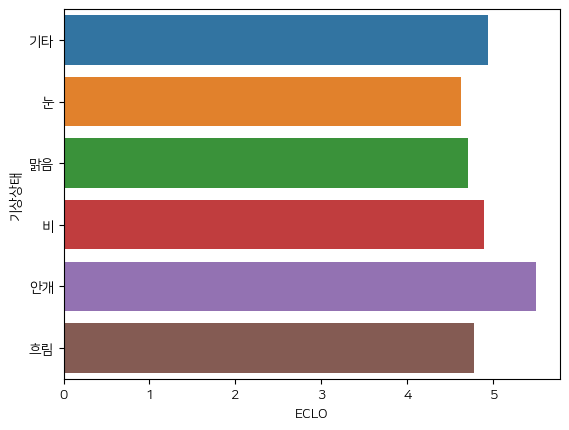

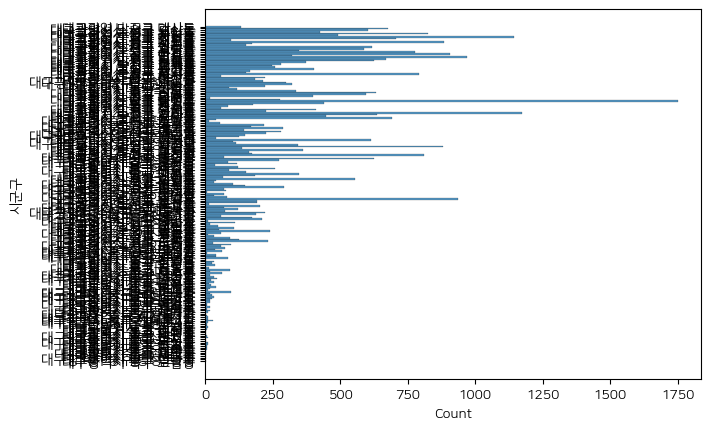

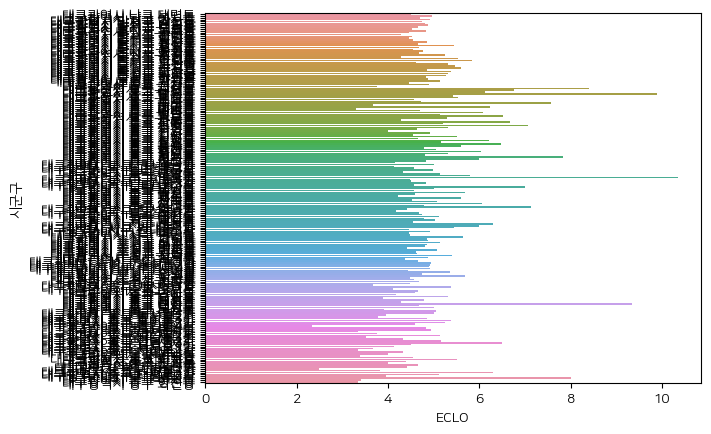

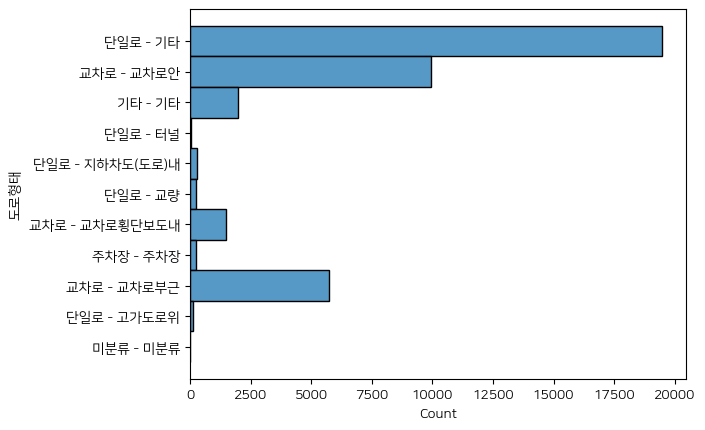

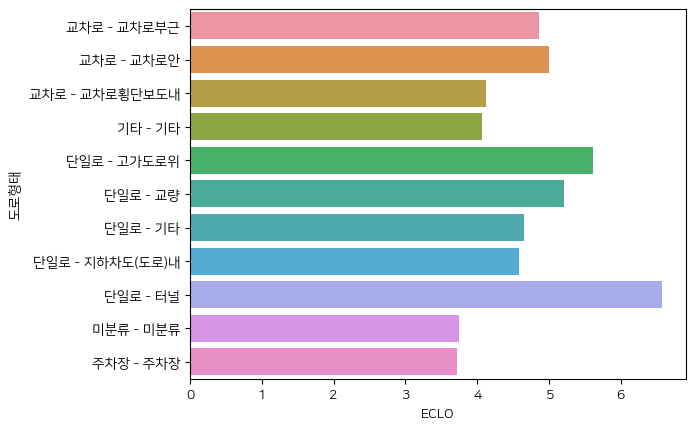

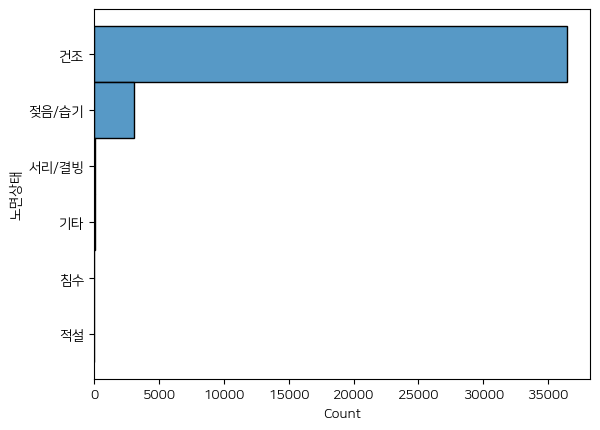

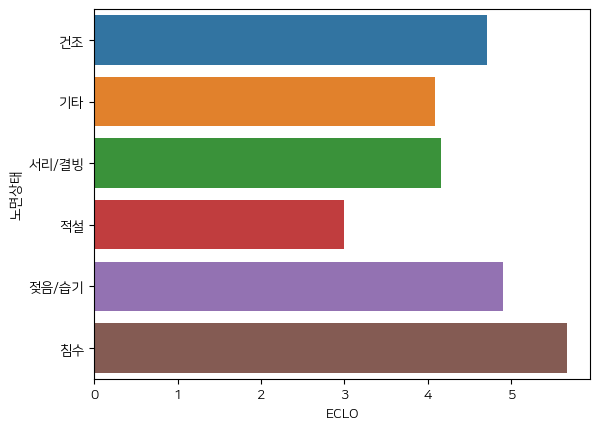

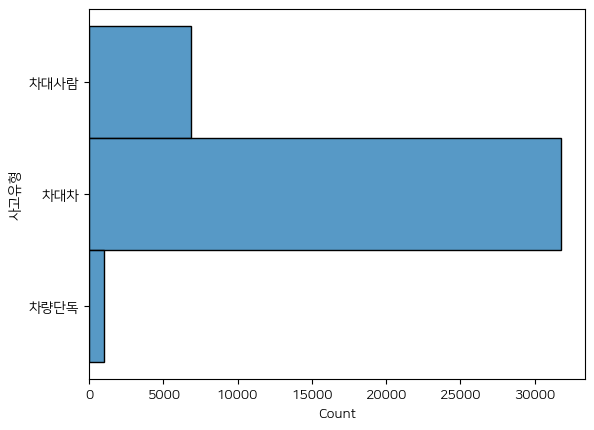

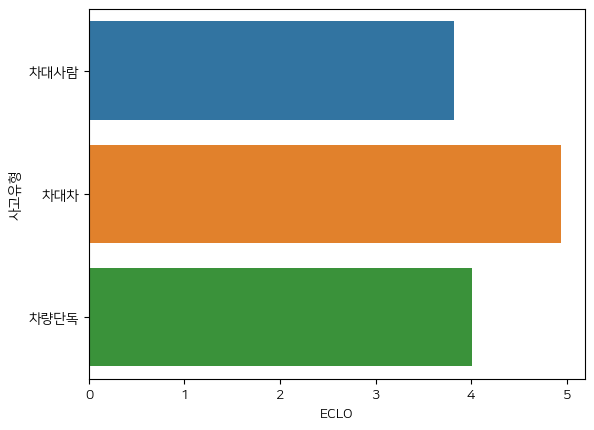

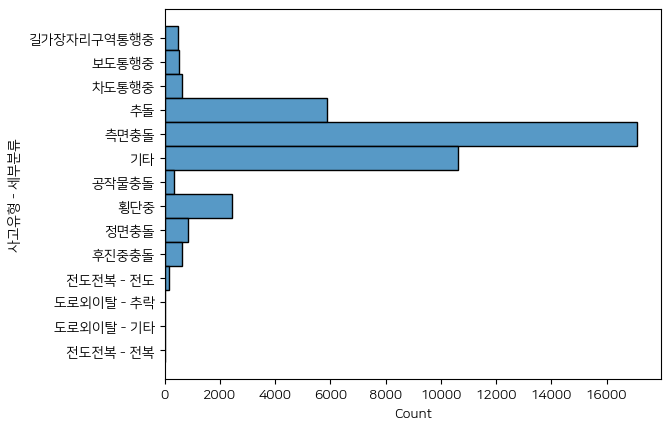

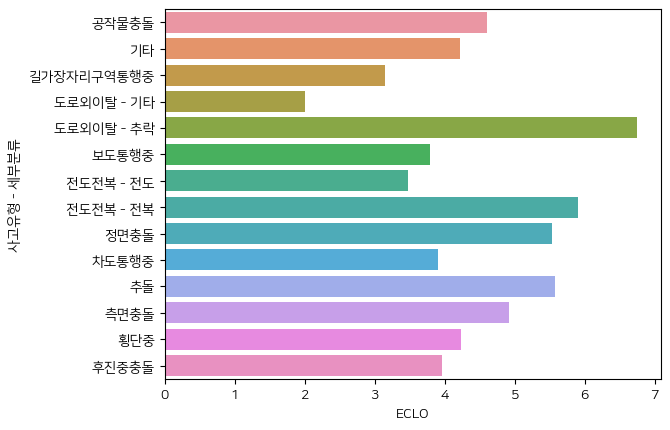

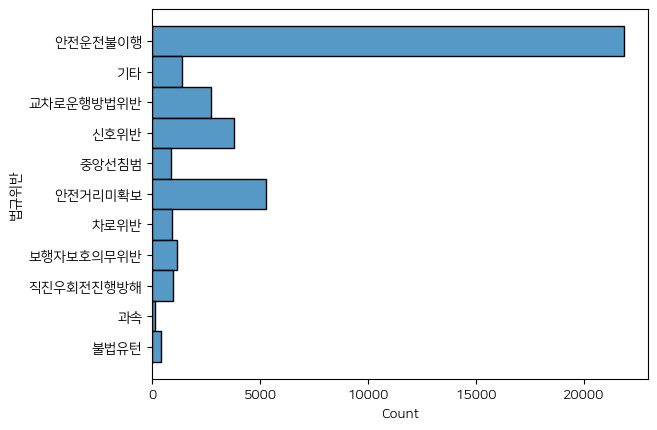

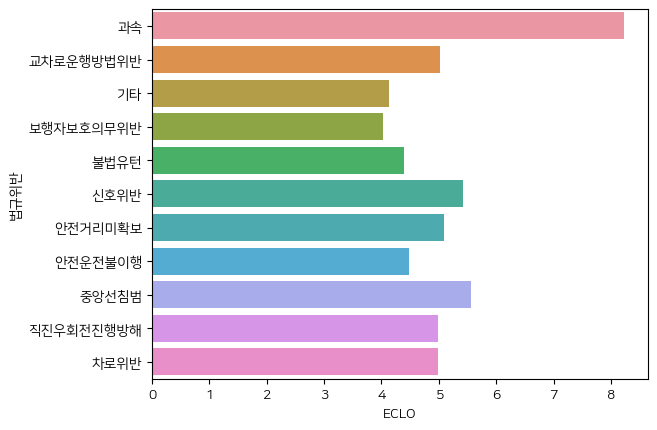

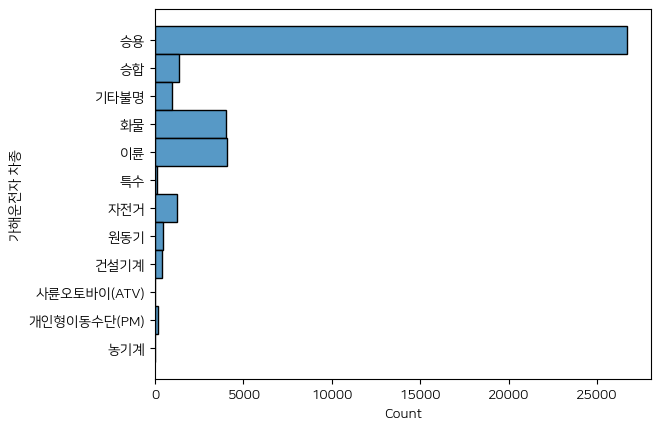

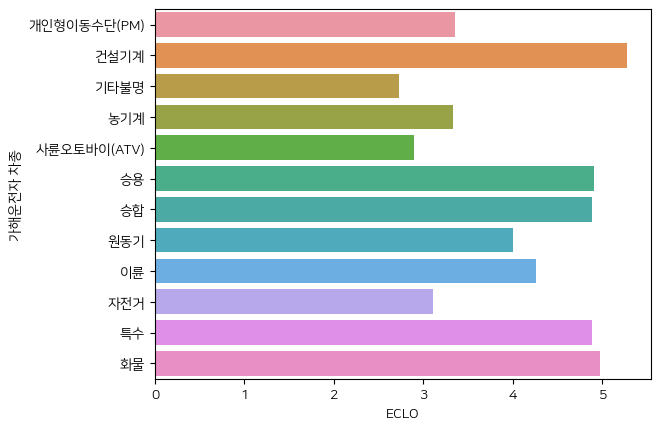

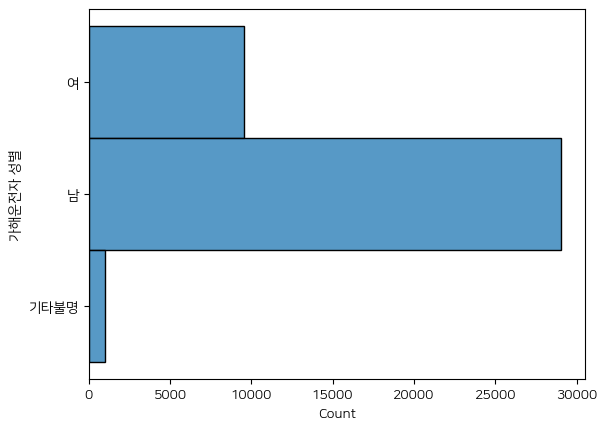

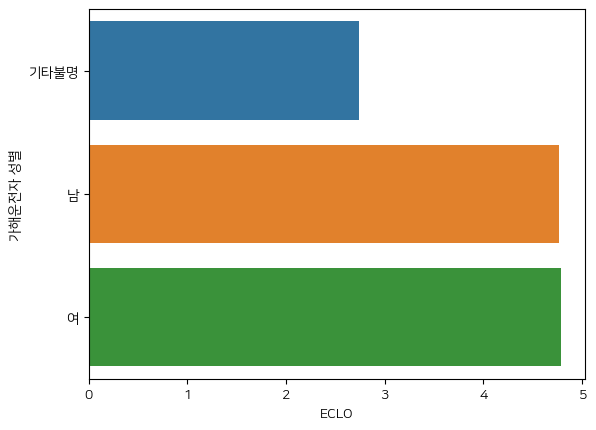

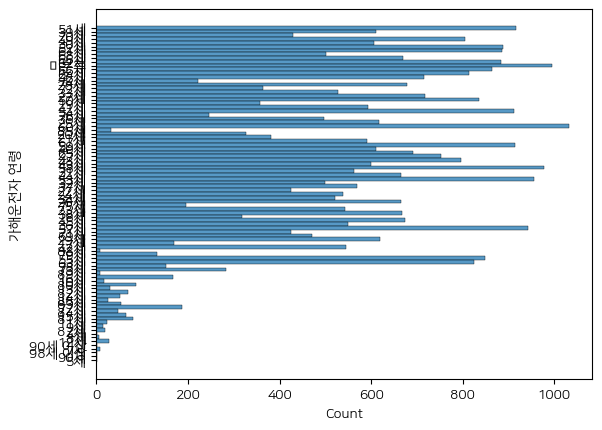

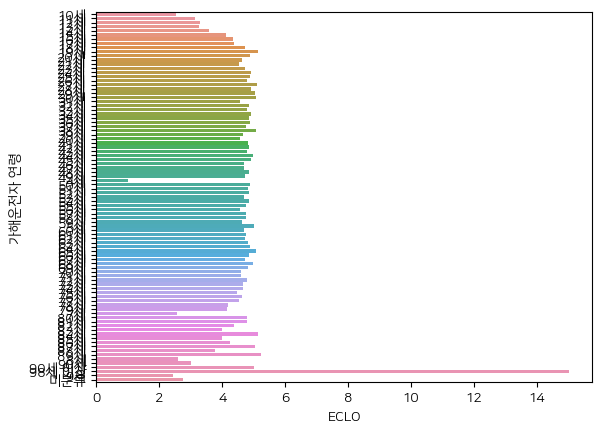

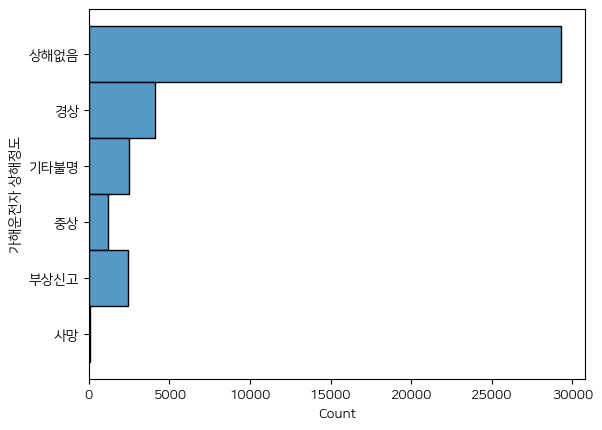

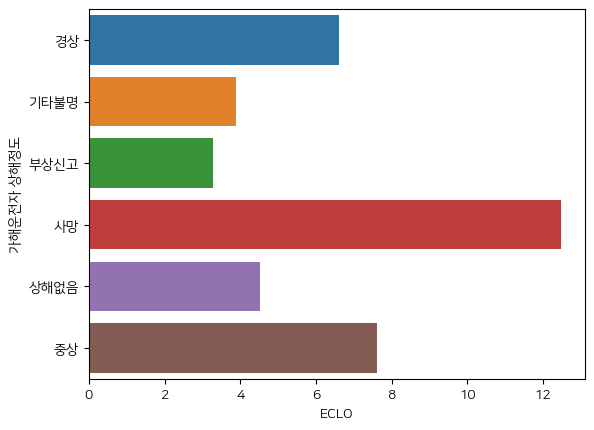

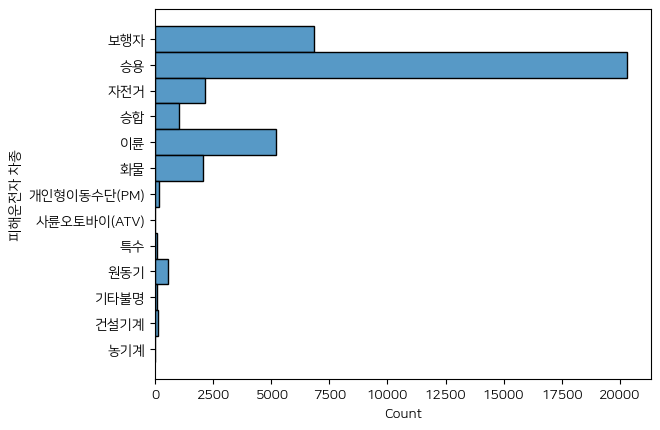

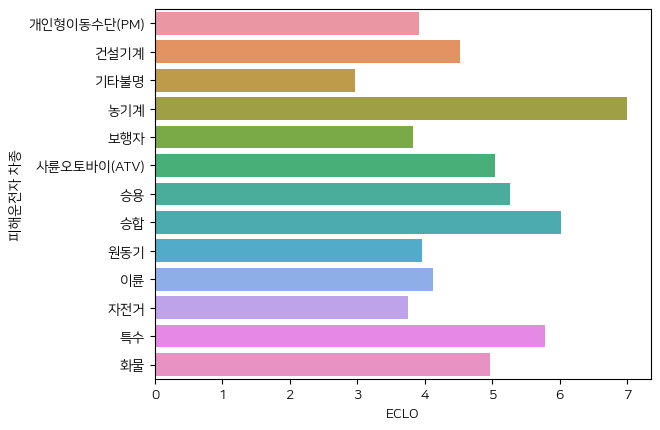

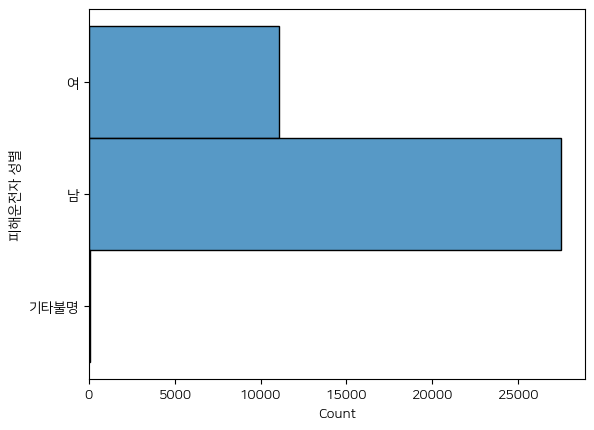

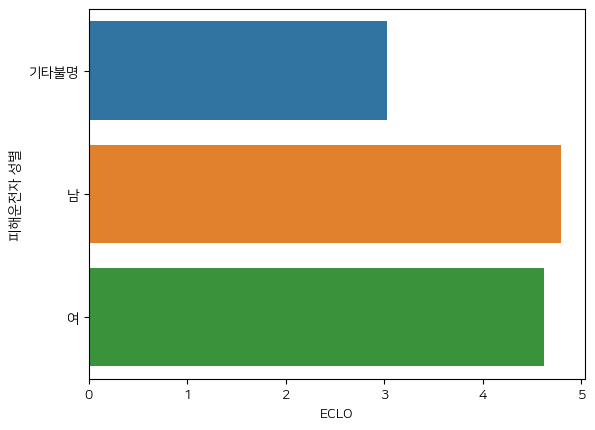

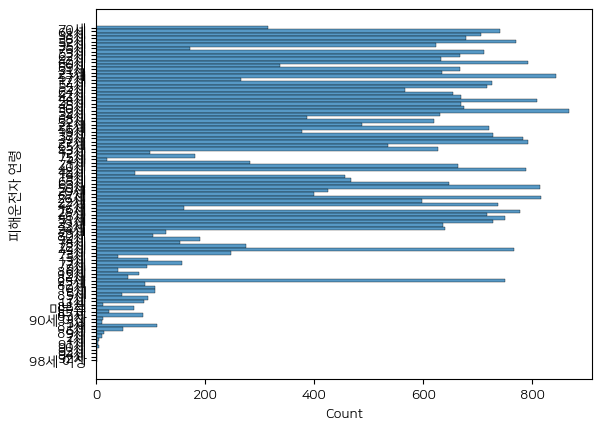

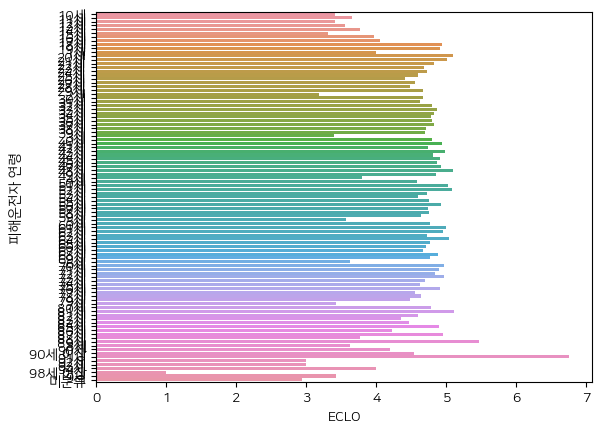

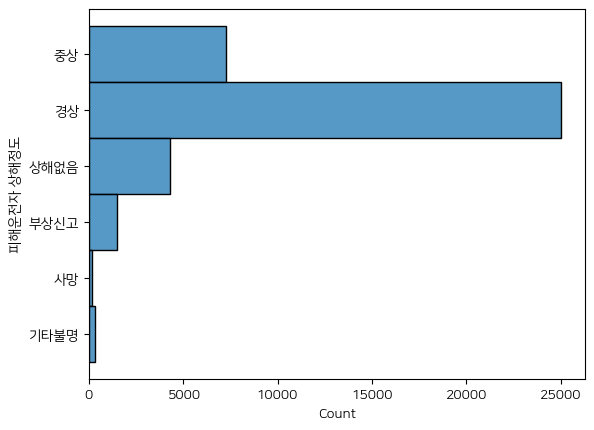

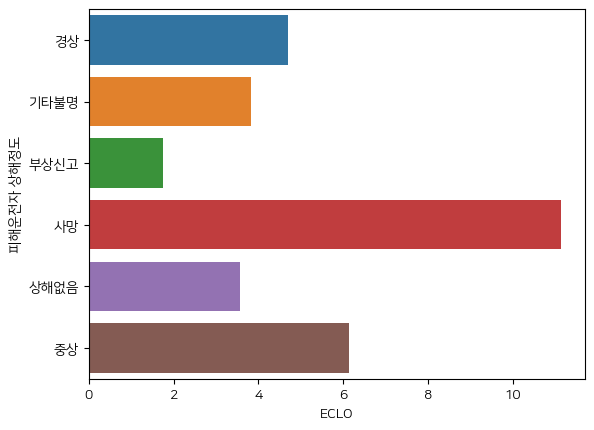

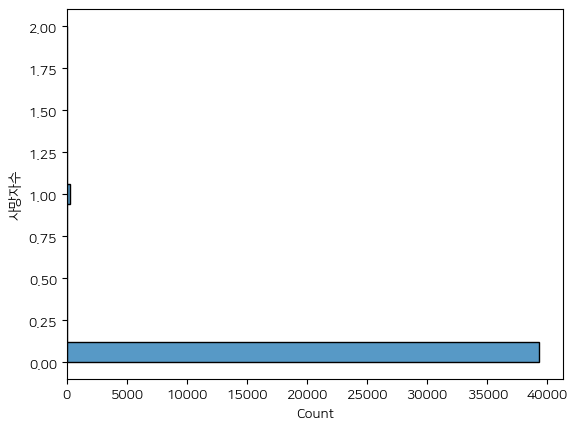

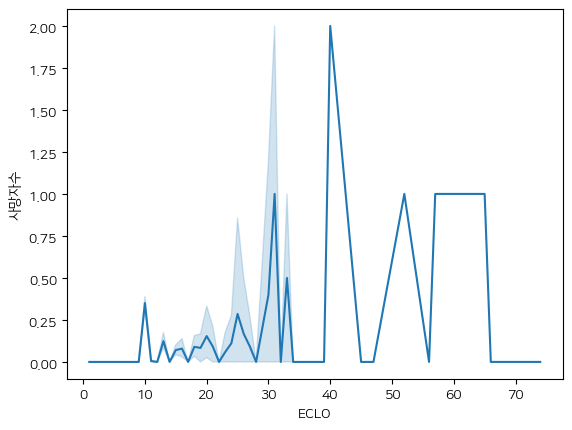

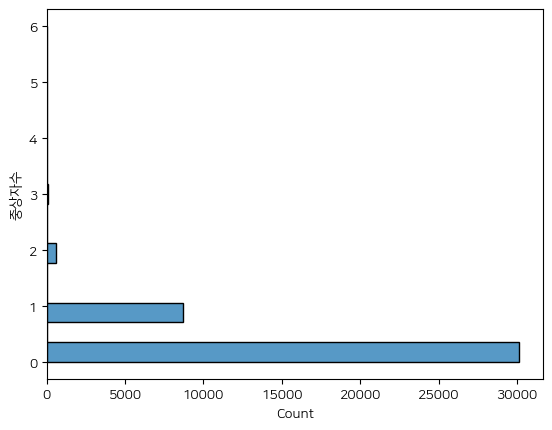

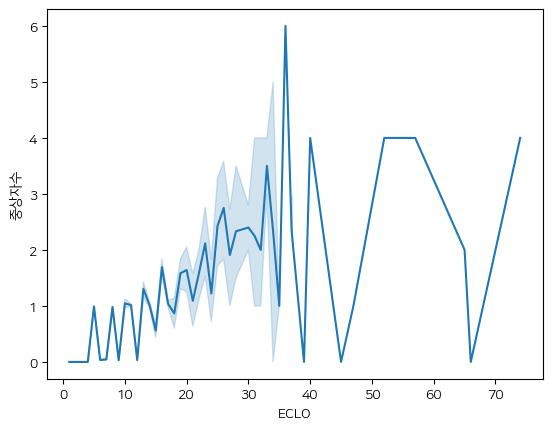

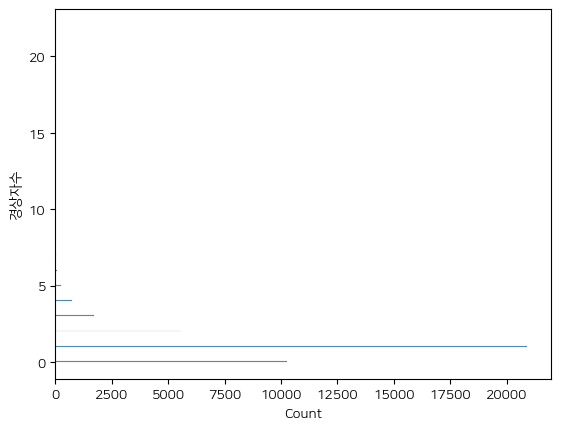

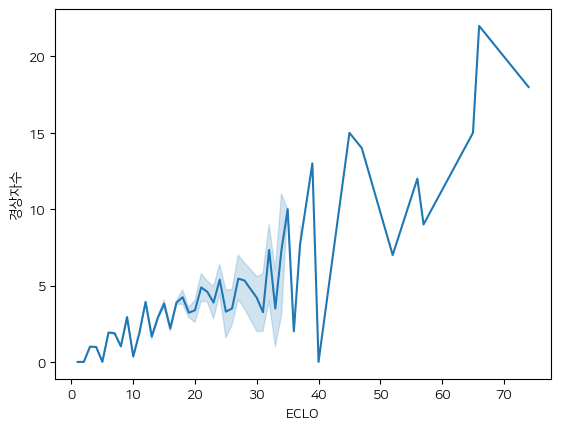

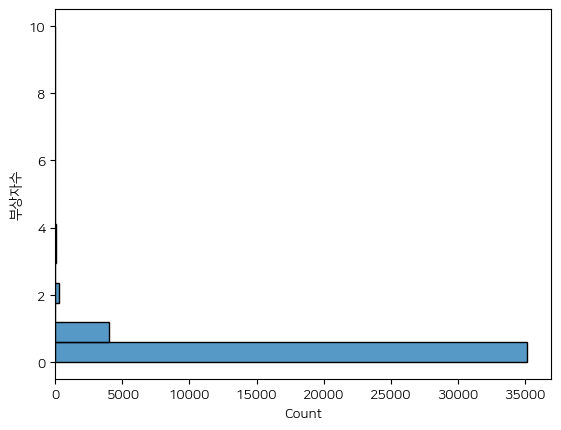

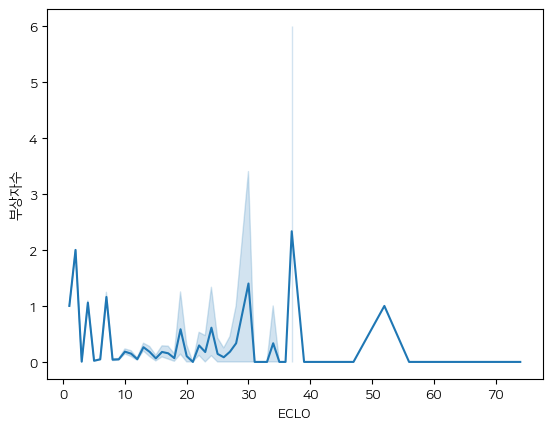

In [24]:
for i, j in zip(train.columns, train.dtypes):
    if i in ['ID', '사고일시', 'ECLO']:
        continue

    if j == 'object':
        tmp = train.groupby(i)['ECLO'].mean().reset_index()
        sns.histplot(data = train, y = i)
        plt.show()

        sns.barplot(data = tmp, y = i, x = 'ECLO')
        plt.show()


    else:
        sns.histplot(data = train, y = i)
        plt.show()

        sns.lineplot(data = train, y = i, x = 'ECLO')
        plt.show()

In [11]:
tmp2

,동가,ECLO
0,가창면,5.321739
1,가천동,5.637931
2,각산동,5.137931
3,갈산동,4.909091
4,감삼동,4.738938
...,...,...
191,호산동,4.606218
192,화원읍,4.864865
193,화전동,3.333333
194,황금동,4.484694


<Axes: xlabel='ECLO', ylabel='동가'>

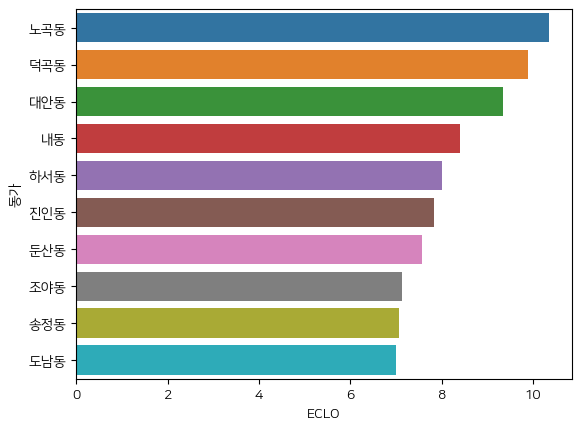

In [29]:
# graph
tmp2 = train.groupby('동가')['ECLO'].mean().sort_values(ascending=False).reset_index()
sns.barplot(data = tmp2.iloc[:10, :], y = '동가', x = 'ECLO')


<Axes: xlabel='ECLO', ylabel='동가'>

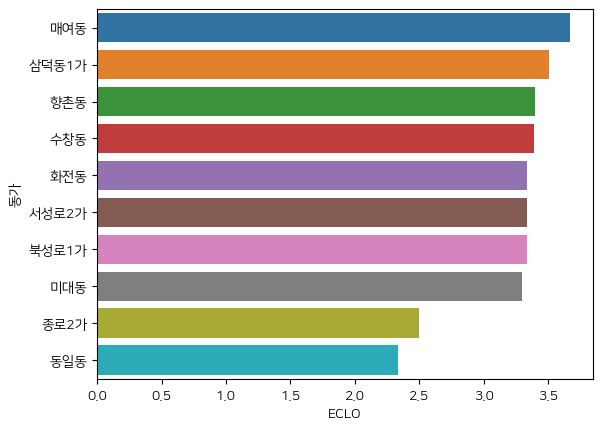

In [28]:
# graph
tmp2 = train.groupby('동가')['ECLO'].mean().sort_values(ascending=False).reset_index()
sns.barplot(data = tmp2.iloc[-10:, :], y = '동가', x = 'ECLO')


<Axes: xlabel='구', ylabel='ECLO'>

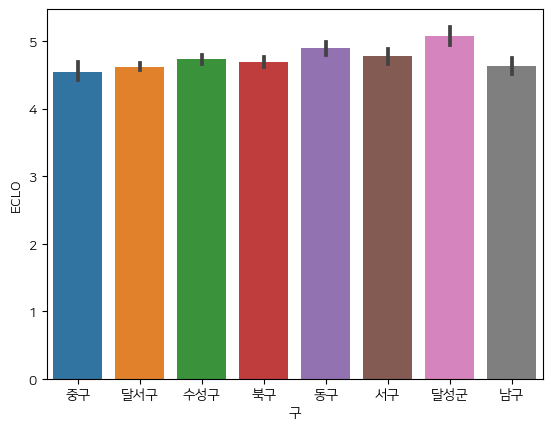

In [31]:
sns.barplot(data = train, x = '구', y = 'ECLO')

<Axes: xlabel='month', ylabel='ECLO'>

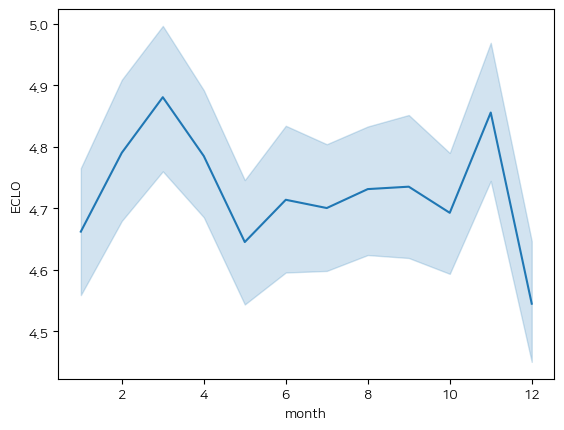

In [32]:
sns.lineplot(data = train, x = 'month', y = 'ECLO')

<Axes: xlabel='day', ylabel='ECLO'>

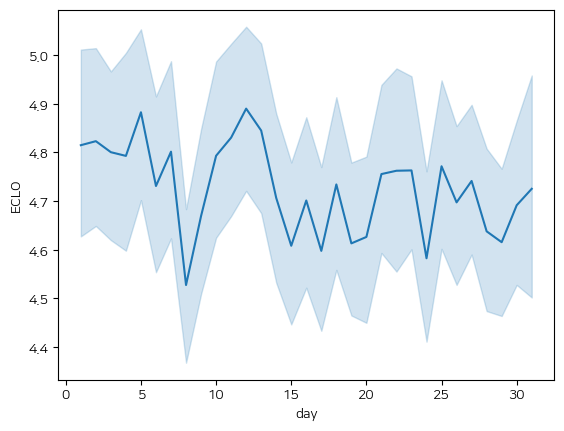

In [33]:
sns.lineplot(data = train, x = 'day', y = 'ECLO')

<Axes: xlabel='hour', ylabel='ECLO'>

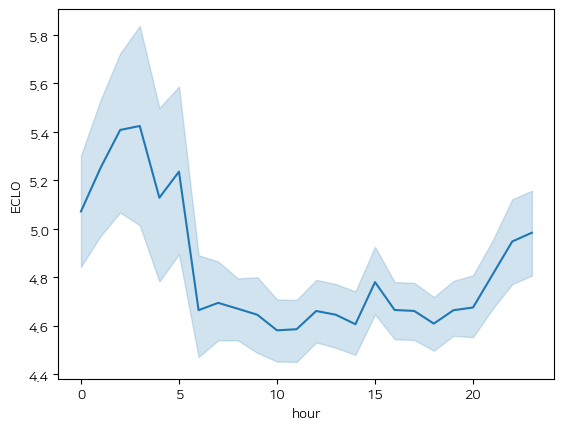

In [34]:
sns.lineplot(data = train, x = 'hour', y = 'ECLO')